In [1]:
################################################################################################################################
#
# FRACDIFF - MONTHLY
#
################################################################################################################################

#===============================================================================================================================
# LIBRARIES
#===============================================================================================================================
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings


from math import sqrt

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

#===============================================================================================================================
# CONFIG
#===============================================================================================================================
%matplotlib inline
#plt.style.use('seaborn-darkgrid')
warnings.filterwarnings('ignore')

In [2]:
#===============================================================================================================================
# DATA: READ
#===============================================================================================================================
seriesId = 'IBOV-monthly'
df = pd.read_csv('Data/Input/'+seriesId+'.csv')

data = df.copy()
data['Date'] =pd.to_datetime(data['Date'], dayfirst=True)
data = data.loc[:, ['Date', 'Close']]
data = data.set_index('Date')
data

,Close
Date,
2000-01-28,16734.39
2000-02-29,17660.20
2000-03-31,17820.37
2000-04-28,15537.60
2000-05-31,14956.61
...,...
2023-08-31,115741.81
2023-09-29,116565.17
2023-10-31,113143.67


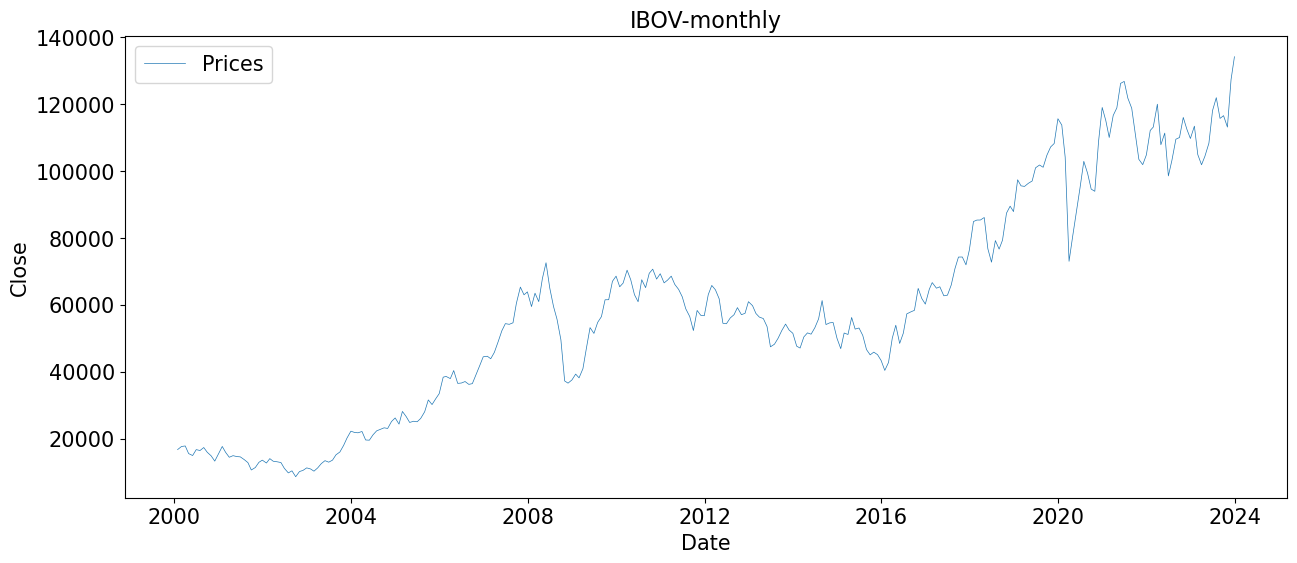

In [3]:
#===============================================================================================================================
# DATA: PLOT
#===============================================================================================================================
plt.figure(figsize=(15,6))
plt.plot(data.index, data['Close'], label = "Prices", linewidth=0.5)
plt.title(seriesId, fontsize=16)
plt.xlabel('Date', fontsize=15)
plt.ylabel('Close', fontsize=15)
plt.tick_params(axis='both', labelsize=15)
plt.legend(loc=2, prop={'size': 15}, bbox_to_anchor=(0,1))
plt.show()

In [4]:
#===============================================================================================================================
# DATA: TRANSF - CONSTANTS
#===============================================================================================================================
THRESHOLD = 1e-3


In [5]:
#===============================================================================================================================
# DATA: TRANSF - FUNCTION WEIGHTS
#===============================================================================================================================
def getWeights_FFD(d, thres=THRESHOLD, lim=10000):
    w, k = [1.], 1                          # Set w as a list and k as one
    ctr = 0                                 # Set ctr
    while True:                             # Loop While
        w_ = -w[-1] / k * (d - k + 1)          # Create the new weight value
        if abs(w_) < thres:break               # End the loop in case the threshold is breached
        w.append(w_)                           # Append the new value of w
        k += 1                                 # Increment k
        ctr += 1                               # Increment ctr
        if ctr == lim - 1:break                # End the loop in case it breaches the limit
    return np.array(w[::-1]).reshape(-1, 1) # Convert the w from list to a numpy array

In [6]:
#===============================================================================================================================
# DATA: TRANSF - FUNCTION FRACDIFF
#===============================================================================================================================
def fracDiff_FFD(series,d,thres=THRESHOLD, w=None):
    #---------------------------------------------------------------------------------------------------------------------------
    # Constant width window (new solution)
    # thres: cut-off weight for the window
    # d: positive fractional, not necessarily bounded [0,1].
    #---------------------------------------------------------------------------------------------------------------------------

    #---------------------------------------------------------------------------------------------------------------------------
    # 1) WEIGHTS
    #---------------------------------------------------------------------------------------------------------------------------
    length = len(series)                                            # Get the length of the series
    #print('len(series)=',length)
    if w is None:                                                   # if w = none
        #w=getWeights_FFD(d,thres,length)                          # Estimate w 
        w=getWeights_FFD(d,thres,)                               # Estimate w 
    width=len(w)-1                                                  # Width define the span of residuals
    
    #print('len(w)=',len(w))
    #print('w')
    #print(np.round(w[-20:],4))
    #print('width=' ,width)

    #---------------------------------------------------------------------------------------------------------------------------
    # 2) Apply WEIGHTS to VALUES
    #---------------------------------------------------------------------------------------------------------------------------
    df= {}
    seriesF,df_=series.fillna(method='ffill').dropna(), pd.Series() # seriesF (forward-filled) and df_ (empty series)
    #print('len(seriesF)=', len(seriesF))
    
    #print('loop for: len(seriesF.index)', len(seriesF.index))
    for iloc1 in range(width,len(seriesF.index)):                   # Loop through each observation of the seriesF
        loc0,loc1=seriesF.index[iloc1-width],seriesF.index[iloc1]      # Get first and last loc's for residuals
        if not np.isfinite(series.loc[loc1]):continue                  # Exclude NAs
        df_[loc1]=np.dot(w.T,seriesF.loc[loc0:loc1])[0]                # Compute residuals for loc1
    df['Close']=df_.copy(deep=True)                                 # Create residuals of the respective OHLC dataframe
    df=pd.concat(df,axis=1)                                         # Convert the series into a dataframe

    #print('len(df_)=', len(df_))
    #print(seriesF[-20:])
    #print(df_[-20:])

    return df


In [7]:
#===============================================================================================================================
# DATA: TRANSF - FUNCTION: ESTIMATES d (ADF statistics)
#===============================================================================================================================
def d_estimates_db(DF,minimum,maximum):
    #---------------------------------------------------------------------------------------------------------------------------
    # Create the output dataframe
    #---------------------------------------------------------------------------------------------------------------------------
    out=pd.DataFrame(columns=['adfStat','pVal','lags','nObs','95% conf','corr'])
    #---------------------------------------------------------------------------------------------------------------------------
    # Copy the dataframe in order to not change it
    #---------------------------------------------------------------------------------------------------------------------------
    df0=DF.copy()
    #---------------------------------------------------------------------------------------------------------------------------
    # Create a range of posible d values and loop throughout them
    #---------------------------------------------------------------------------------------------------------------------------
    for d in np.linspace(minimum,maximum,11):
        #--------------------------------------------------------------------
        # Create the log of close prices
        #--------------------------------------------------------------------
        #df1=np.log(df0['Close'])
        df1=df0['Close']
        #--------------------------------------------------------------------
        # Estimate the FracDiff residuals
        #--------------------------------------------------------------------
        df2=fracDiff_FFD(df1,d,thres=THRESHOLD)
        #--------------------------------------------------------------------
        # Correlation between the log prices and the FracDiff residuals
        #--------------------------------------------------------------------
        corr=np.corrcoef(df1.loc[df2.index],df2['Close'])[0,1]

        #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        print('d_estimates_db: d =',round(d,3), '  correlation =', round(corr,3))
        #print('df2')
        #print(df2)
        #~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
        
        #--------------------------------------------------------------------
        # Estimate a unit root test to the FraDiff residuals
        #--------------------------------------------------------------------
        df2=adfuller(df2['Close'],regression='c',autolag='AIC')
        #--------------------------------------------------------------------
        # Save all the results in the out dataframe
        #--------------------------------------------------------------------
        out.loc[d]=list(df2[:4])+[df2[4]['5%']]+[corr] # with critical value
    # Return the out dataframe            
    return out

In [8]:
#THRESHOLD = 1e-3
#d=0.01
#df1=data['Close']
#dftemp=fracDiff_FFD(df1,d,thres=THRESHOLD)
#dftemp

In [9]:
#===============================================================================================================================
# DATA: TRANSF - FUNCTION OPTIMAL d
#===============================================================================================================================
def optimal_d(DF, alpha=0.035, minimum = 0, maximum = 1):
    #---------------------------------------------------------------------------------------------------------------------------
    # Copy the dataframe
    #---------------------------------------------------------------------------------------------------------------------------
    df = DF.copy()
    #---------------------------------------------------------------------------------------------------------------------------
    # Estimate the best d based on the basic d range
    #---------------------------------------------------------------------------------------------------------------------------
    path = './Data/Output/1.Econometric-4.FracDiff-2.Monthly/'
    out = d_estimates_db(df,minimum,maximum)
    out.to_excel(path+'optimal_d-out1.xlsx')
    #---------------------------------------------------------------------------------------------------------------------------
    # A try-except block to handle erros while getting a d with better decimals
    #---------------------------------------------------------------------------------------------------------------------------
    try:
        #-----------------------------------------------------------------------------------------------------------------------
        # Get the d value which critical value is closest to and higher than alpha
        #-----------------------------------------------------------------------------------------------------------------------
        d1 = out[out['pVal']>alpha].index.values[-1]
        #-----------------------------------------------------------------------------------------------------------------------
        # Get the d value which critical value is closest to and lower than alpha
        #-----------------------------------------------------------------------------------------------------------------------
        d2 = out[out['pVal']<alpha].index.values[0]
        #-----------------------------------------------------------------------------------------------------------------------
        # Estimate the best d between d1 and d2
        #-----------------------------------------------------------------------------------------------------------------------
        out = d_estimates_db(df,d1,d2)
        out.to_excel(path+'optimal_d-out2.xlsx')
        try:
            #-------------------------------------------------------------------------------------------------------------------
            # Get the d value which critical value is closest to and higher than alpha
            #-------------------------------------------------------------------------------------------------------------------
            d1 = out[out['pVal']>alpha].index.values[-1]
            #-------------------------------------------------------------------------------------------------------------------
            # Get the d value which critical value is closest to and lower than alpha
            #-------------------------------------------------------------------------------------------------------------------
            d2 = out[out['pVal']<alpha].index.values[0]
            #-------------------------------------------------------------------------------------------------------------------
            # Estimate the best d between d1 and d2
            #-------------------------------------------------------------------------------------------------------------------
            out = d_estimates_db(df,d1,d2)
            out.to_excel(path+'optimal_d-out3.xlsx')
            try:
                #---------------------------------------------------------------------------------------------------------------
                # Get the d value which critical value is closest to and higher than alpha
                #---------------------------------------------------------------------------------------------------------------
                d1 = out[out['pVal']>alpha].index.values[-1]
                #---------------------------------------------------------------------------------------------------------------
                # Get the d value which critical value is closest to and lower than alpha
                #---------------------------------------------------------------------------------------------------------------
                d2 = out[out['pVal']<alpha].index.values[0]
                #---------------------------------------------------------------------------------------------------------------
                # Set d as the average between d1 and d2 with four decimals
                #---------------------------------------------------------------------------------------------------------------
                d = round((d1+d2)/2,4)    
            except:
                #---------------------------------------------------------------------------------------------------------------
                # In case the try fails, assign d with the critical value which is closest to and higher than alpha
                #---------------------------------------------------------------------------------------------------------------
                d = out[out['pVal']<alpha].index.values[0]
        except:
            #-------------------------------------------------------------------------------------------------------------------
            # In case the try fails, assign d with the critical value which is closest to and higher than alpha
            #-------------------------------------------------------------------------------------------------------------------
            d = out[out['pVal']<alpha].index.values[0]
    except:
        #-----------------------------------------------------------------------------------------------------------------------
        # In case the try fails, assign d with the critical value which is closest to and higher than alpha
        #-----------------------------------------------------------------------------------------------------------------------
        d = out[out['pVal']<alpha].index.values[0]
    # Return the d value
    return d

In [10]:
#===============================================================================================================================
# DATA: TRANSF - RUN ESTIMATES d - PRICES
#===============================================================================================================================
out = d_estimates_db(data,0,1)
out

#-----------------------------------------------------------------
# diff   adfStat          pVal  lags    nObs   95% conf      corr
#-----------------------------------------------------------------
# 0.0  -0.463371  8.989684e-01  11.0  5931.0  -2.862027  1.000000
# 0.1  -1.297984  6.300941e-01   7.0  5433.0  -2.862072  0.995251
# 0.2  -2.320128  1.655583e-01   6.0  5440.0  -2.862071  0.973129
# 0.3  -3.218056  1.896303e-02  15.0  5540.0  -2.862062  0.928268
# 0.4  -3.802464  2.882210e-03  26.0  5635.0  -2.862053  0.852800
# 0.5  -4.951445  2.766524e-05  26.0  5717.0  -2.862046  0.739250
# 0.6  -6.218377  5.296934e-08  26.0  5777.0  -2.862040  0.591374
# 0.7  -7.333671  1.110861e-10  28.0  5818.0  -2.862037  0.427604
# 0.8  -8.930194  9.862735e-15  28.0  5851.0  -2.862034  0.282918
# 0.9 -14.201131  1.787042e-26  16.0  5889.0  -2.862031  0.162188
# 1.0 -21.237276  0.000000e+00  10.0  5931.0  -2.862027  0.026296

d_estimates_db: d = 0.0   correlation = 1.0
d_estimates_db: d = 0.1   correlation = 0.989
d_estimates_db: d = 0.2   correlation = 0.941
d_estimates_db: d = 0.3   correlation = 0.854
d_estimates_db: d = 0.4   correlation = 0.74
d_estimates_db: d = 0.5   correlation = 0.609
d_estimates_db: d = 0.6   correlation = 0.492
d_estimates_db: d = 0.7   correlation = 0.391
d_estimates_db: d = 0.8   correlation = 0.305
d_estimates_db: d = 0.9   correlation = 0.217
d_estimates_db: d = 1.0   correlation = 0.118


,adfStat,pVal,lags,nObs,95% conf,corr
0.0,-0.011251,9.575917e-01,4.0,283.0,-2.871808,1.000000
0.1,-0.980139,7.604390e-01,4.0,222.0,-2.874649,0.989254
0.2,-1.443347,5.613277e-01,4.0,211.0,-2.875337,0.940749
0.3,-2.208367,2.032226e-01,4.0,218.0,-2.874891,0.854188
0.4,-2.966972,3.809609e-02,4.0,229.0,-2.874245,0.740090
0.5,-7.170560,2.811767e-10,0.0,244.0,-2.873459,0.608514
0.6,-8.809796,2.005687e-14,0.0,254.0,-2.872987,0.492301
0.7,-10.347001,2.595302e-18,0.0,262.0,-2.872636,0.390586
0.8,-11.870489,6.521153e-22,0.0,270.0,-2.872305,0.305305
0.9,-10.095358,1.094505e-17,2.0,274.0,-2.872147,0.216690


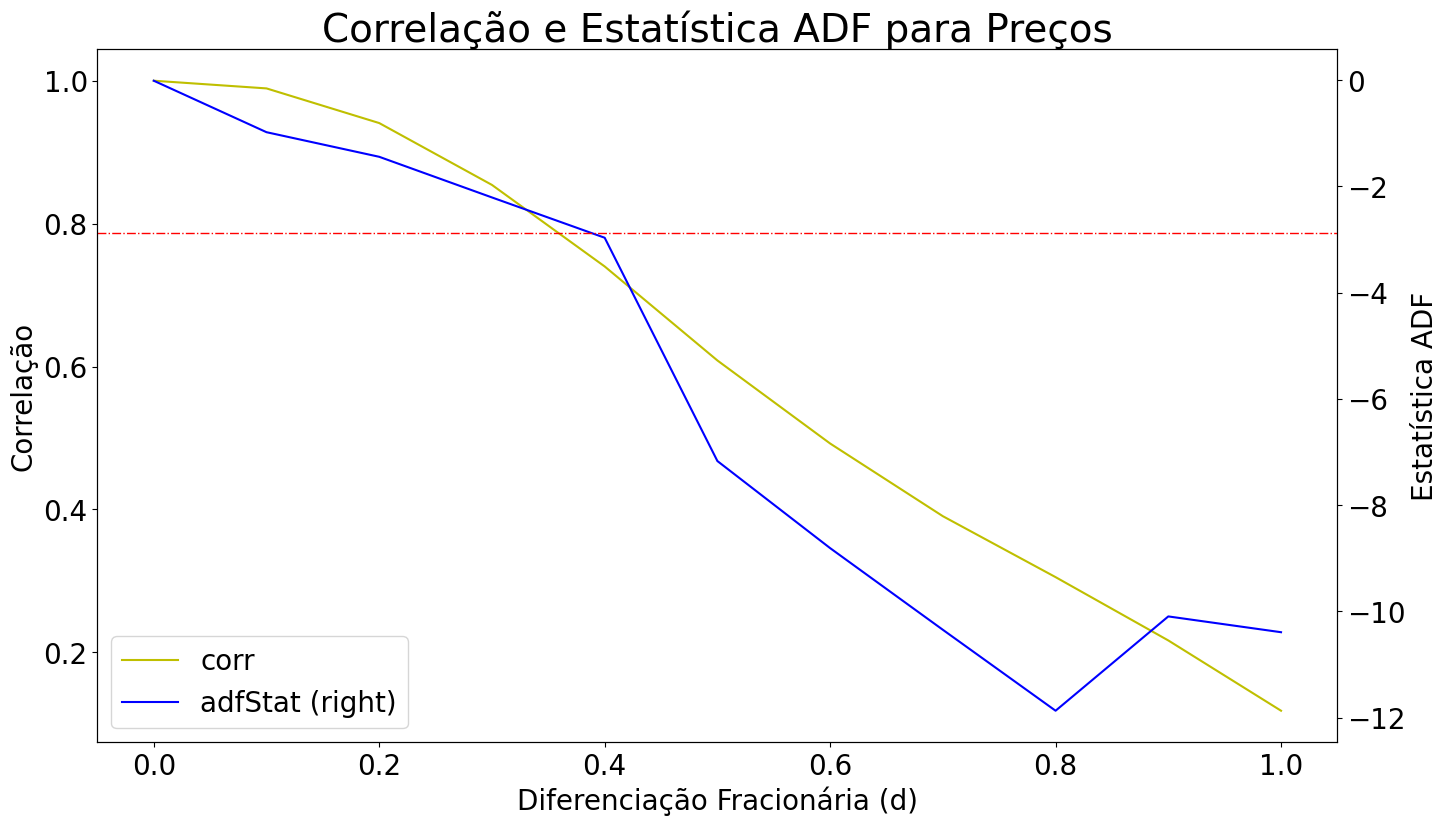

In [11]:
#===============================================================================================================================
# DATA: ADF TEST, CORRELATION vs d - PRICES
#===============================================================================================================================
#-------------------------------------------------------------------------------------------------------------------------------
# Plot: out For d = 0.3 , p-value = 0.048, correlation = 0.85 > 0.8 (critical point).
#-------------------------------------------------------------------------------------------------------------------------------
ax1 = out['corr'].plot(figsize=(16, 9), color='y')
ax2 = out['adfStat'].plot(secondary_y=True, fontsize=20, color='b', ax=ax1)
ax1.set_title('Correlação e Estatística ADF para Preços', fontsize=28)
ax1.set_xlabel('Diferenciação Fracionária (d)', fontsize=20)
ax1.set_ylabel('Correlação', fontsize=20)
ax2.set_ylabel('Estatística ADF', fontsize=20)
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1+h2, l1+l2, loc='lower left', fontsize=20)
plt.axhline(out['95% conf'].mean(),linewidth=1, color='r',linestyle='-.');
# Tip: get 2 legends aligned without overlapping:
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1+h2, l1+l2, loc='lower left', fontsize=20)

In [12]:
#===============================================================================================================================
# DATA: TRANSF - RUN OPTIMAL - PRICES - [0,1]
#===============================================================================================================================
d = optimal_d(data, 0.035, 0, 1)
d
#-------------------------------------------------------------------------------------------------------------------------------
# d = 0.4035
#-------------------------------------------------------------------------------------------------------------------------------

d_estimates_db: d = 0.0   correlation = 1.0
d_estimates_db: d = 0.1   correlation = 0.989
d_estimates_db: d = 0.2   correlation = 0.941
d_estimates_db: d = 0.3   correlation = 0.854
d_estimates_db: d = 0.4   correlation = 0.74
d_estimates_db: d = 0.5   correlation = 0.609
d_estimates_db: d = 0.6   correlation = 0.492
d_estimates_db: d = 0.7   correlation = 0.391
d_estimates_db: d = 0.8   correlation = 0.305
d_estimates_db: d = 0.9   correlation = 0.217
d_estimates_db: d = 1.0   correlation = 0.118
d_estimates_db: d = 0.4   correlation = 0.74
d_estimates_db: d = 0.41   correlation = 0.727
d_estimates_db: d = 0.42   correlation = 0.715
d_estimates_db: d = 0.43   correlation = 0.704
d_estimates_db: d = 0.44   correlation = 0.693
d_estimates_db: d = 0.45   correlation = 0.679
d_estimates_db: d = 0.46   correlation = 0.664
d_estimates_db: d = 0.47   correlation = 0.649
d_estimates_db: d = 0.48   correlation = 0.635
d_estimates_db: d = 0.49   correlation = 0.622
d_estimates_db: d = 0.5   cor

0.4035

In [13]:
#===============================================================================================================================
# DATA: TRANSF - RUN FRACDIFF - PRICES
#===============================================================================================================================
fracdiff_residuals = fracDiff_FFD(data['Close'],d)
fracdiff_residuals

,Close
2004-07-30,5368.052427
2004-08-31,5161.160284
2004-09-30,5154.415176
2004-10-29,4563.160784
2004-11-30,6511.315022
...,...
2023-08-31,15408.101301
2023-09-29,17566.001656
2023-10-31,13856.481278
2023-11-30,29236.898941


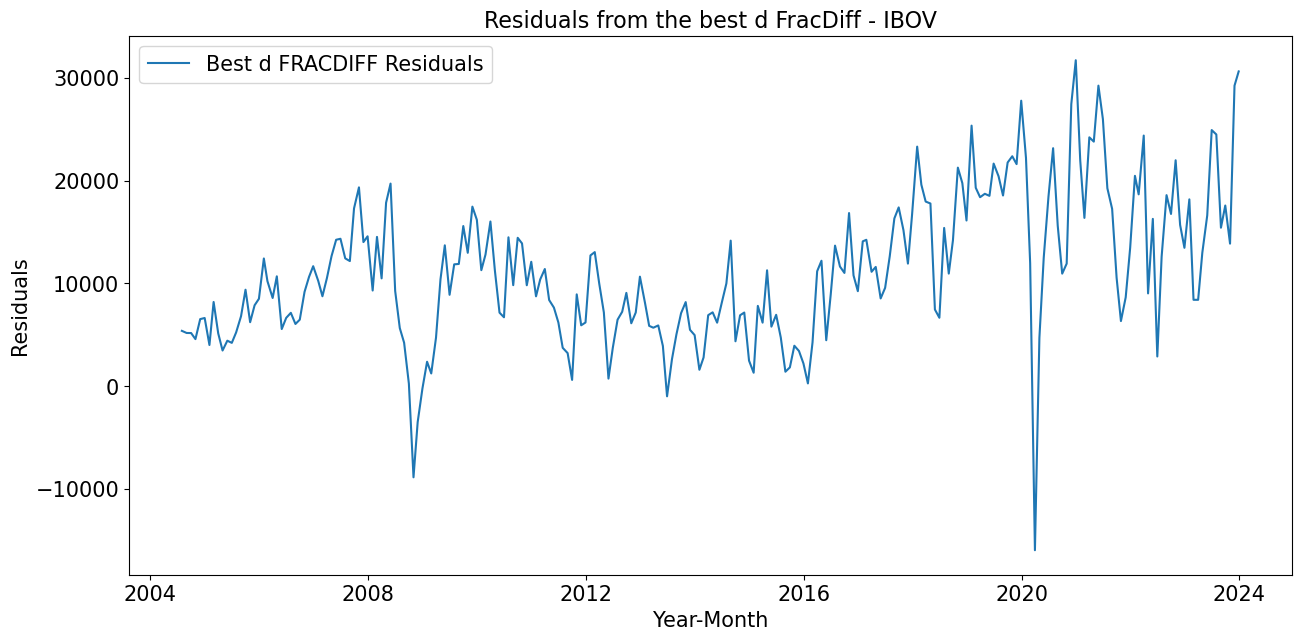

In [14]:
#===============================================================================================================================
# DATA: TRANSF - PLOT - FRACDIFF RESIDUALS - PRICES
#===============================================================================================================================

# Set the figure size
plt.figure(figsize=(15,7))

# Plot the residuals
plt.plot(fracdiff_residuals.index, fracdiff_residuals, label = "Best d FRACDIFF Residuals")

# Set the title of the graph
plt.title('Residuals from the best d FracDiff - IBOV', fontsize=16)

# Set the x- and y- axis labels and ticks sizes
plt.xlabel('Year-Month', fontsize=15)
plt.ylabel('Residuals', fontsize=15)
plt.tick_params(axis='both', labelsize=15)

# Set the plot legend location
plt.legend(loc=2, prop={'size': 15}, bbox_to_anchor=(0,1))

plt.show()

In [15]:
#===============================================================================================================================
# DATA: TRANSF - STATIONARITY - FRACDIFF RESIDUALS - PRICES (ADF Test)
#===============================================================================================================================
df2=adfuller(fracdiff_residuals, regression='c', autolag='AIC')
ADF_statistics = df2[0]
p_value = df2[1]
print('ADF statistics =', round(ADF_statistics,2),chr(9), 'p_value =', round(p_value,3))

#-------------------------------------------------------------------------------------------------------------------------------
# ADF statistics = -3.0 p_value = 0.035 < 0.05
#
#-------------------------------------------------------------------------------------------------------------------------------
# ***** STATIONARY *****
#-------------------------------------------------------------------------------------------------------------------------------

ADF statistics = -3.0 	 p_value = 0.035


In [16]:
#===============================================================================================================================
# DATA: TRANSF - CORRELATION - FRACDIFF RESIDUALS - PRICES
#===============================================================================================================================
fracdiff_residuals.rename(columns={'Close':'Residuals'}, inplace=True)
new_df = pd.concat([data['Close'], fracdiff_residuals], axis=1).dropna()
print('Correlation = ', round(new_df.corr().loc['Close','Residuals'],4))

#-------------------------------------------------------------------------------------------------------------------------------
# Correlation =  0.7349
#-------------------------------------------------------------------------------------------------------------------------------

Correlation =  0.7349


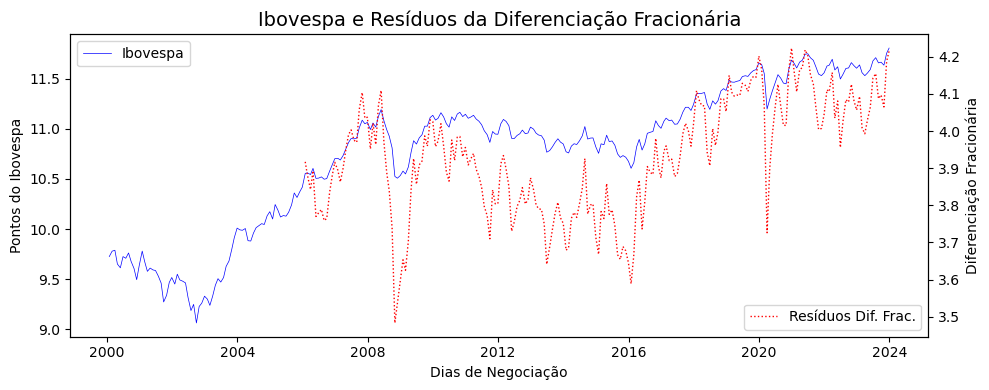

In [38]:
#===============================================================================================================================
# DATA: TRANSF - PLOT - FRACDIFF RESIDUALS - PRICES
#===============================================================================================================================
fig, ax1 = plt.subplots(figsize=(10,4))
ax1.plot(data['Close']     , 'b-',  label='Ibovespa', linewidth=0.5)
ax1.legend(loc=2)
ax1.set_xlabel('Dias de Negociação')
ax1.set_ylabel('Pontos do Ibovespa')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.plot(fracdiff_residuals  , 'r', label='Resíduos Dif. Frac.', linewidth=1, linestyle='dotted')
ax2.set_ylabel('Diferenciação Fracionária')
ax2.legend(loc=4)

plt.title('Ibovespa e Resíduos da Diferenciação Fracionária', fontsize=14)
#fig.autofmt_xdate()
plt.tight_layout()
#plt.show()

In [18]:
fracdiff_residuals.to_csv('Data/Input/IBOV-FracDiff-Prc-Monthly.csv')

In [19]:
#===============================================================================================================================
# DATA: RECOVER - FRACDIFF - FUNCTION
#===============================================================================================================================
def fracDiff_FFD_recover(series,d,thres=THRESHOLD, w=None,series_ori=None):

    #---------------------------------------------------------------------------------------------------------------------------
    # Length of series
    #---------------------------------------------------------------------------------------------------------------------------
    length = len(series)
    
    #---------------------------------------------------------------------------------------------------------------------------
    # Width of w
    #---------------------------------------------------------------------------------------------------------------------------
    width=len(w)-1
    
    #---------------------------------------------------------------------------------------------------------------------------
    # Apply weights to values
    #---------------------------------------------------------------------------------------------------------------------------
    df= {}
    # seriesF (forward-filled) and df_ (empty series)
    #seriesF,df_=series.fillna(method='ffill').dropna(), pd.Series() 
    seriesF,df_=series, pd.Series() 
    
    print('width=',width, 'len(seriesF.index)=',len(seriesF.index))
    print('')
    #---------------------------------------------------------------------------------------------------------------------------
    # Loop seriesF
    #---------------------------------------------------------------------------------------------------------------------------
    for iloc1 in range(0,len(seriesF.index)):
        #-----------------------------------------------------------------------------------------------------------------------
        # First loc
        #-----------------------------------------------------------------------------------------------------------------------
        #loc0=seriesF.index[iloc1-width]
        #-----------------------------------------------------------------------------------------------------------------------
        # Last loc
        #-----------------------------------------------------------------------------------------------------------------------
        loc1=seriesF.index[iloc1]

        print('')
        print('Loop: iloc1=', iloc1, ' | loc1=', loc1)
        #-----------------------------------------------------------------------------------------------------------------------
        # Exclude NAs
        #-----------------------------------------------------------------------------------------------------------------------
        if not (np.isfinite(series.loc[loc1])).any():continue
        #-----------------------------------------------------------------------------------------------------------------------
        # Compute df_: Dot Product w x SeriesF[loc0:loc1]
        #-----------------------------------------------------------------------------------------------------------------------
        #df_[loc1]=np.dot(w.T,seriesF.loc[loc0:loc1])[0]
        #-----------------------------------------------------------------------------------------------------------------------
        # Compute df_: Recover
        #-----------------------------------------------------------------------------------------------------------------------
        print('')
        print('seriesF[loc1]=', seriesF.loc[loc1,'Residuals'])
        print('series_ori[loc1]=', series_ori.loc[loc1])
        print('w[iloc1]=', np.round(w[iloc1],6))

        df_[loc1] = np.round((seriesF.loc[loc1,'Residuals'] - (seriesF.loc[loc1,'Residuals']-series_ori.loc[loc1]*w[iloc1]))/w[iloc1],6)
    #---------------------------------------------------------------------------------------------------------------------------
    # Create residuals of the respective OHLC dataframe
    #---------------------------------------------------------------------------------------------------------------------------
    df['Close']=df_.copy(deep=True)
    #---------------------------------------------------------------------------------------------------------------------------
    # Convert the series into a dataframe
    #---------------------------------------------------------------------------------------------------------------------------
    df=pd.concat(df,axis=1)
    #print('len(df_)=', len(df_))
    #print(seriesF[-20:])
    #print(df_[-20:])

    return df

In [20]:
#===============================================================================================================================
# DATA: RECOVER - WEIGHTS - PRICES
#===============================================================================================================================
w_FFD = getWeights_FFD(d, thres=1e-6, lim=5942-446+1)
print(len(w_FFD))
#w_FFD

5497


In [21]:
#===============================================================================================================================
# DATA: RECOVER - FRACDIFF - RUN
#===============================================================================================================================
fracdiff_recover = fracDiff_FFD_recover(fracdiff_residuals, d, THRESHOLD, w_FFD, data['Close'])


width= 5496 len(seriesF.index)= 234


Loop: iloc1= 0  | loc1= 2004-07-30 00:00:00

seriesF[loc1]= 5368.052427393715
series_ori[loc1]= 22336.87
w[iloc1]= [-2.e-06]

Loop: iloc1= 1  | loc1= 2004-08-31 00:00:00

seriesF[loc1]= 5161.160284217607
series_ori[loc1]= 22803.19
w[iloc1]= [-2.e-06]

Loop: iloc1= 2  | loc1= 2004-09-30 00:00:00

seriesF[loc1]= 5154.415176368862
series_ori[loc1]= 23245.24
w[iloc1]= [-2.e-06]

Loop: iloc1= 3  | loc1= 2004-10-29 00:00:00

seriesF[loc1]= 4563.160783603385
series_ori[loc1]= 23052.18
w[iloc1]= [-2.e-06]

Loop: iloc1= 4  | loc1= 2004-11-30 00:00:00

seriesF[loc1]= 6511.315021641985
series_ori[loc1]= 25128.33
w[iloc1]= [-2.e-06]

Loop: iloc1= 5  | loc1= 2004-12-30 00:00:00

seriesF[loc1]= 6618.29606383154
series_ori[loc1]= 26196.25
w[iloc1]= [-2.e-06]

Loop: iloc1= 6  | loc1= 2005-01-31 00:00:00

seriesF[loc1]= 3991.079704020847
series_ori[loc1]= 24350.62
w[iloc1]= [-2.e-06]

Loop: iloc1= 7  | loc1= 2005-02-28 00:00:00

seriesF[loc1]= 8177.273108775436
ser


Loop: iloc1= 190  | loc1= 2020-05-29 00:00:00

seriesF[loc1]= 12470.800058501292
series_ori[loc1]= 87402.59
w[iloc1]= [-2.e-06]

Loop: iloc1= 191  | loc1= 2020-06-30 00:00:00

seriesF[loc1]= 18446.69657271509
series_ori[loc1]= 95055.82
w[iloc1]= [-2.e-06]

Loop: iloc1= 192  | loc1= 2020-07-31 00:00:00

seriesF[loc1]= 23146.643481677835
series_ori[loc1]= 102912.24
w[iloc1]= [-2.e-06]

Loop: iloc1= 193  | loc1= 2020-08-31 00:00:00

seriesF[loc1]= 15604.53440611255
series_ori[loc1]= 99369.15
w[iloc1]= [-2.e-06]

Loop: iloc1= 194  | loc1= 2020-09-30 00:00:00

seriesF[loc1]= 10937.532811376077
series_ori[loc1]= 94603.38
w[iloc1]= [-2.e-06]

Loop: iloc1= 195  | loc1= 2020-10-30 00:00:00

seriesF[loc1]= 11909.862555343221
series_ori[loc1]= 93952.4
w[iloc1]= [-2.e-06]

Loop: iloc1= 196  | loc1= 2020-11-30 00:00:00

seriesF[loc1]= 27437.61999147985
series_ori[loc1]= 108893.32
w[iloc1]= [-2.e-06]

Loop: iloc1= 197  | loc1= 2020-12-30 00:00:00

seriesF[loc1]= 31709.601012468353
series_ori[loc1]=

In [22]:
#===============================================================================================================================
# DATA: RECOVER - FRACDIFF - PRICES
#===============================================================================================================================
fracdiff_recover

,Close
2004-07-30,[22336.87]
2004-08-31,[22803.19]
2004-09-30,[23245.24]
2004-10-29,[23052.18]
2004-11-30,[25128.33]
...,...
2023-08-31,[115741.81]
2023-09-29,[116565.17]
2023-10-31,[113143.67]
2023-11-30,[127331.120001]


In [23]:
#*******************************************************************************************************************************
#
# LOG
#
#*******************************************************************************************************************************

#===============================================================================================================================
# DATA: LOG
#===============================================================================================================================
data = df.loc[:, ['Date']]
data['Date'] =pd.to_datetime(data['Date'], dayfirst=True)
data['Close']= np.log(df.loc[:,'Close'])
data = data.set_index('Date')
data


,Close
Date,
2000-01-28,9.725221
2000-02-29,9.779069
2000-03-31,9.788097
2000-04-28,9.651018
2000-05-31,9.612909
...,...
2023-08-31,11.659117
2023-09-29,11.666206
2023-10-31,11.636414


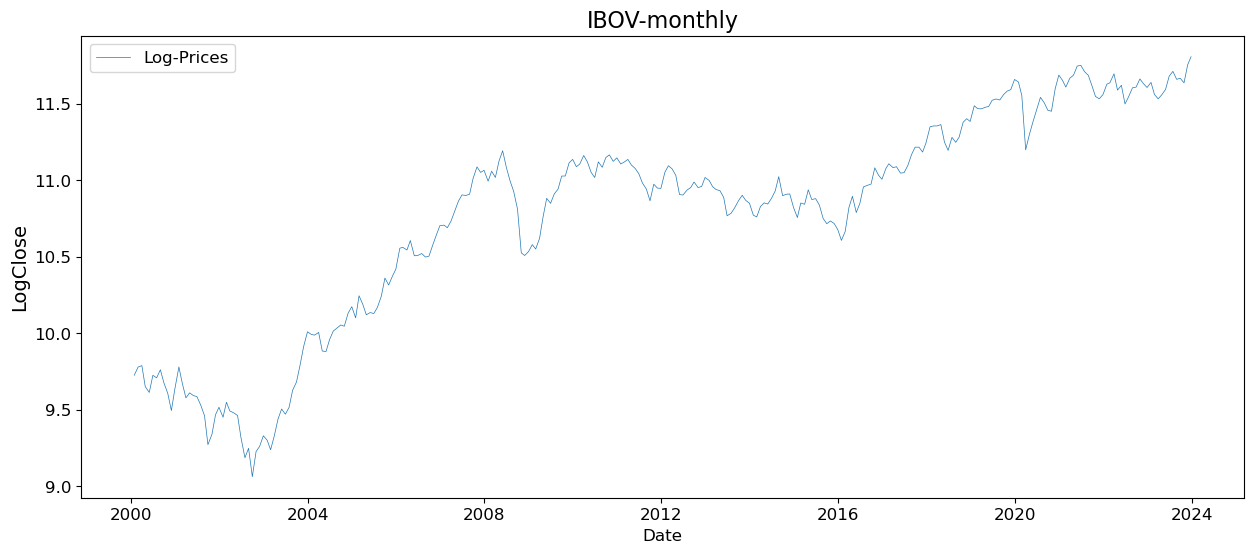

In [24]:
#===============================================================================================================================
# DATA: PLOT - LOG
#===============================================================================================================================
plt.figure(figsize=(15,6))
plt.plot(data.index, data['Close'], label = "Log-Prices", linewidth=0.5)
plt.title(seriesId, fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('LogClose', fontsize=14)
plt.tick_params(axis='both', labelsize=12)
plt.legend(loc=2, prop={'size': 12}, bbox_to_anchor=(0,1))
plt.show()

In [25]:
#===============================================================================================================================
# DATA: TRANSF - ESTIMATES d - LOG
#===============================================================================================================================
out = d_estimates_db(data,0,1)
out

#----------------------------------------------------------------
#        adfStat          pVal  lags    nObs   95% conf      corr
#----------------------------------------------------------------
# 0.0  -0.999280  7.535267e-01  18.0  5924.0  -2.862028  1.000000
# 0.1  -1.944972  3.112096e-01   6.0  5434.0  -2.862072  0.995770
# 0.2  -2.463225  1.246803e-01  19.0  5427.0  -2.862073  0.975986
# 0.3  -3.184014  2.092888e-02  19.0  5536.0  -2.862062  0.939273
# 0.4  -3.620041  5.389245e-03  25.0  5636.0  -2.862053  0.879927
# 0.5  -4.575915  1.430372e-04  26.0  5717.0  -2.862046  0.781757
# 0.6  -5.507772  2.003778e-06  26.0  5777.0  -2.862040  0.642494
# 0.7  -6.941478  1.022448e-09  26.0  5820.0  -2.862037  0.469729
# 0.8  -8.866962  1.431788e-14  26.0  5853.0  -2.862034  0.313413
# 0.9 -13.903174  5.685239e-26  15.0  5890.0  -2.862031  0.175507
# 1.0 -16.889955  1.046976e-29  17.0  5924.0  -2.862028  0.012783

d_estimates_db: d = 0.0   correlation = 1.0
d_estimates_db: d = 0.1   correlation = 0.979
d_estimates_db: d = 0.2   correlation = 0.878
d_estimates_db: d = 0.3   correlation = 0.73
d_estimates_db: d = 0.4   correlation = 0.57
d_estimates_db: d = 0.5   correlation = 0.377
d_estimates_db: d = 0.6   correlation = 0.312
d_estimates_db: d = 0.7   correlation = 0.298
d_estimates_db: d = 0.8   correlation = 0.246
d_estimates_db: d = 0.9   correlation = 0.146
d_estimates_db: d = 1.0   correlation = 0.051


,adfStat,pVal,lags,nObs,95% conf,corr
0.0,-0.921864,7.806869e-01,1.0,286.0,-2.871699,1.000000
0.1,-1.971621,2.991531e-01,0.0,226.0,-2.874415,0.978849
0.2,-2.901579,4.516474e-02,0.0,215.0,-2.875079,0.878183
0.3,-4.380995,3.206839e-04,0.0,222.0,-2.874649,0.729814
0.4,-5.768635,5.457725e-07,0.0,233.0,-2.874026,0.570179
0.5,-7.380543,8.495510e-11,0.0,244.0,-2.873459,0.376844
0.6,-8.815846,1.935391e-14,0.0,254.0,-2.872987,0.311669
0.7,-10.085005,1.161628e-17,0.0,262.0,-2.872636,0.298078
0.8,-11.682145,1.731110e-21,0.0,270.0,-2.872305,0.245705
0.9,-13.394124,4.703955e-25,0.0,276.0,-2.872070,0.146391


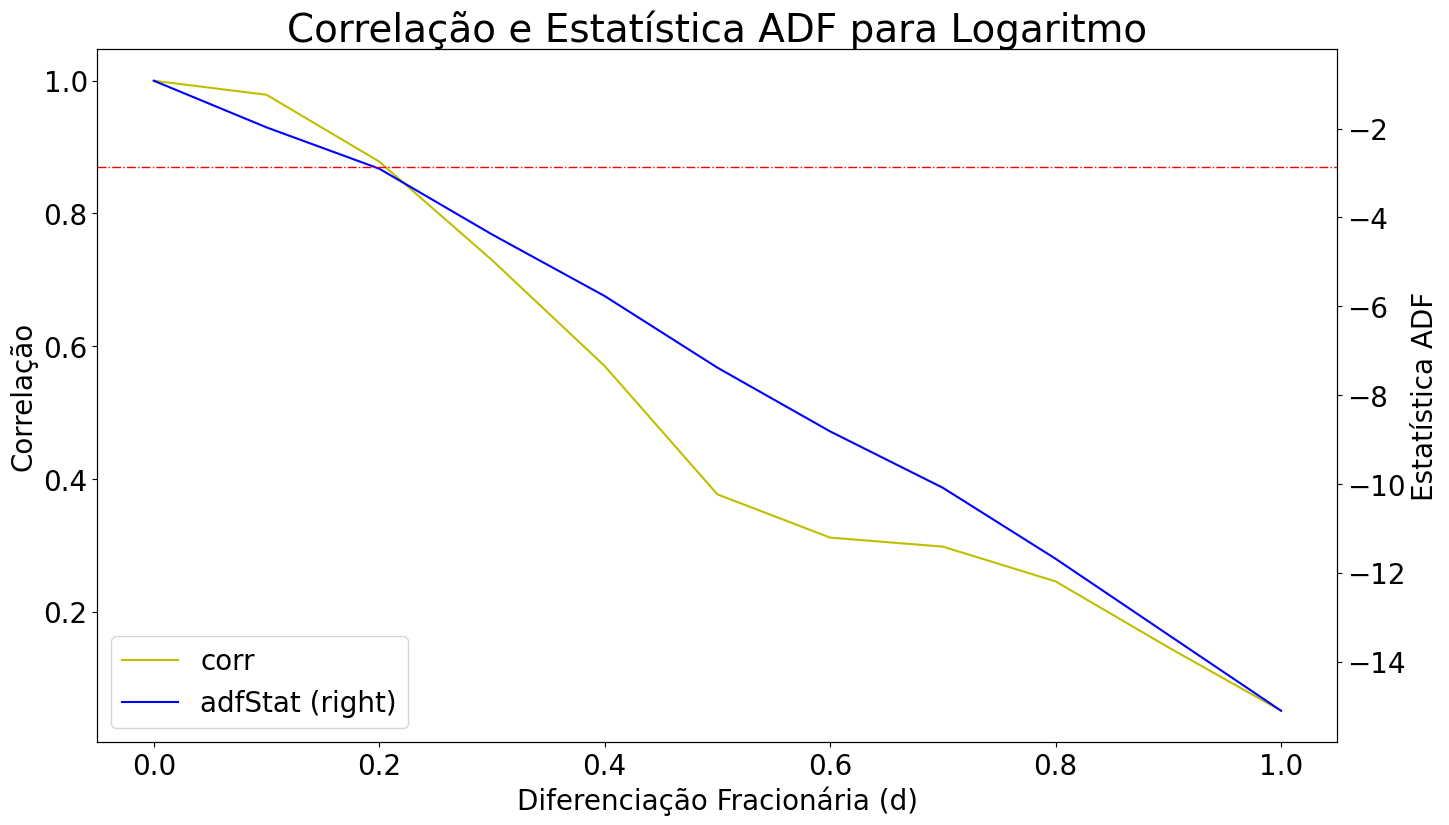

In [26]:
#===============================================================================================================================
# DATA: PLOT - ADF Stat, CORR vs d - LOG
#===============================================================================================================================
#-------------------------------------------------------------------------------------------------------------------------------
# Plot: out For d = 0.3 , p-value = 0.048, correlation = 0.85 > 0.8 (critical point).
#-------------------------------------------------------------------------------------------------------------------------------
ax1 = out['corr'].plot(figsize=(16, 9), color='y')
ax2 = out['adfStat'].plot(secondary_y=True, fontsize=20, color='b', ax=ax1)
ax1.set_title('Correlação e Estatística ADF para Logaritmo', fontsize=28)
ax1.set_xlabel('Diferenciação Fracionária (d)', fontsize=20)
ax1.set_ylabel('Correlação', fontsize=20)
ax2.set_ylabel('Estatística ADF', fontsize=20)
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1+h2, l1+l2, loc='lower left', fontsize=20)
plt.axhline(out['95% conf'].mean(),linewidth=1, color='r',linestyle='-.');
# Tip!
# To get 2 legends aligned without overlapping:
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1+h2, l1+l2, loc='lower left', fontsize=20)

In [27]:
#===============================================================================================================================
# DATA: TRANSF - OPTIMAL d - LOG
#===============================================================================================================================
d = optimal_d(data, 0.035, 0, 1)
d
#-------------------------------------------------------------------------------------------------------------------------------
# d = 0.2085
#-------------------------------------------------------------------------------------------------------------------------------

d_estimates_db: d = 0.0   correlation = 1.0
d_estimates_db: d = 0.1   correlation = 0.979
d_estimates_db: d = 0.2   correlation = 0.878
d_estimates_db: d = 0.3   correlation = 0.73
d_estimates_db: d = 0.4   correlation = 0.57
d_estimates_db: d = 0.5   correlation = 0.377
d_estimates_db: d = 0.6   correlation = 0.312
d_estimates_db: d = 0.7   correlation = 0.298
d_estimates_db: d = 0.8   correlation = 0.246
d_estimates_db: d = 0.9   correlation = 0.146
d_estimates_db: d = 1.0   correlation = 0.051
d_estimates_db: d = 0.2   correlation = 0.878
d_estimates_db: d = 0.21   correlation = 0.865
d_estimates_db: d = 0.22   correlation = 0.852
d_estimates_db: d = 0.23   correlation = 0.837
d_estimates_db: d = 0.24   correlation = 0.822
d_estimates_db: d = 0.25   correlation = 0.806
d_estimates_db: d = 0.26   correlation = 0.791
d_estimates_db: d = 0.27   correlation = 0.772
d_estimates_db: d = 0.28   correlation = 0.756
d_estimates_db: d = 0.29   correlation = 0.742
d_estimates_db: d = 0.3   cor

0.2085

In [28]:
#===============================================================================================================================
# DATA: TRANSF - FRACDIFF - LOG
#===============================================================================================================================
fracdiff_residuals = fracDiff_FFD(data['Close'],d)

fracdiff_residuals

,Close
2006-01-31,3.917126
2006-02-24,3.881832
2006-03-31,3.842665
2006-04-28,3.892926
2006-05-31,3.770014
...,...
2023-08-31,4.087320
2023-09-29,4.097383
2023-10-31,4.065104
2023-11-30,4.187422


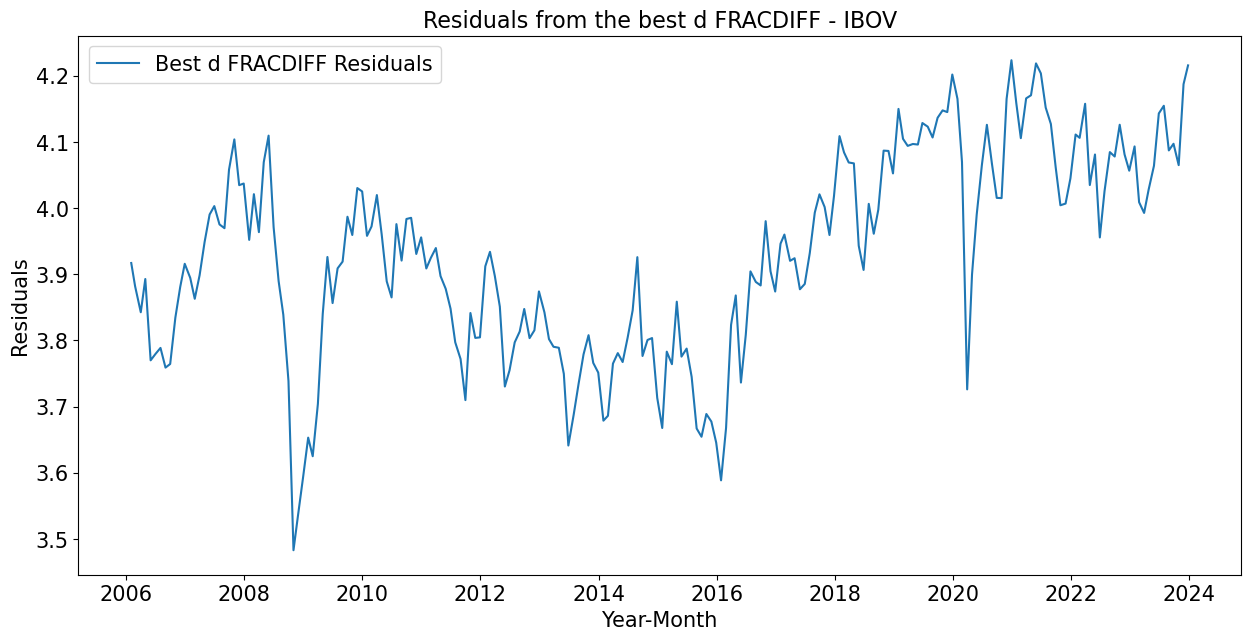

In [29]:
#===============================================================================================================================
# DATA: PLOT - FRACDIFF - LOG
#===============================================================================================================================

# Set the figure size
plt.figure(figsize=(15,7))

# Plot the residuals
plt.plot(fracdiff_residuals.index, fracdiff_residuals, label = "Best d FRACDIFF Residuals")

# Set the title of the graph
plt.title('Residuals from the best d FRACDIFF - IBOV', fontsize=16)

# Set the x- and y- axis labels and ticks sizes
plt.xlabel('Year-Month', fontsize=15)
plt.ylabel('Residuals', fontsize=15)
plt.tick_params(axis='both', labelsize=15)

# Set the plot legend location
plt.legend(loc=2, prop={'size': 15}, bbox_to_anchor=(0,1))

plt.show()

In [30]:
#===============================================================================================================================
# DATA: TRANSF - STATIONARITY - LOG (ADF Test)
#===============================================================================================================================
df2=adfuller(fracdiff_residuals, regression='c', autolag='AIC')
ADF_statistics = df2[0]
p_value = df2[1]
print('ADF statistics =', round(ADF_statistics,2),chr(9), 'p_value =', round(p_value,3))

#-------------------------------------------------------------------------------------------------------------------------------
# ADF statistics = -3.0 p_value = 0.034 < 0.05
#
#-------------------------------------------------------------------------------------------------------------------------------
# ***** STATIONARY *****
#-------------------------------------------------------------------------------------------------------------------------------

ADF statistics = -3.0 	 p_value = 0.034


In [31]:
#===============================================================================================================================
# DATA: TRANSF - CORRELATION - LOG
#===============================================================================================================================
fracdiff_residuals.rename(columns={'Close':'Residuals'}, inplace=True)
new_df = pd.concat([data['Close'], fracdiff_residuals], axis=1).dropna()
print('Correlation = ', round(new_df.corr().loc['Close','Residuals'],4))

#-------------------------------------------------------------------------------------------------------------------------------
# Correlation =  0.8672
#-------------------------------------------------------------------------------------------------------------------------------

Correlation =  0.8672


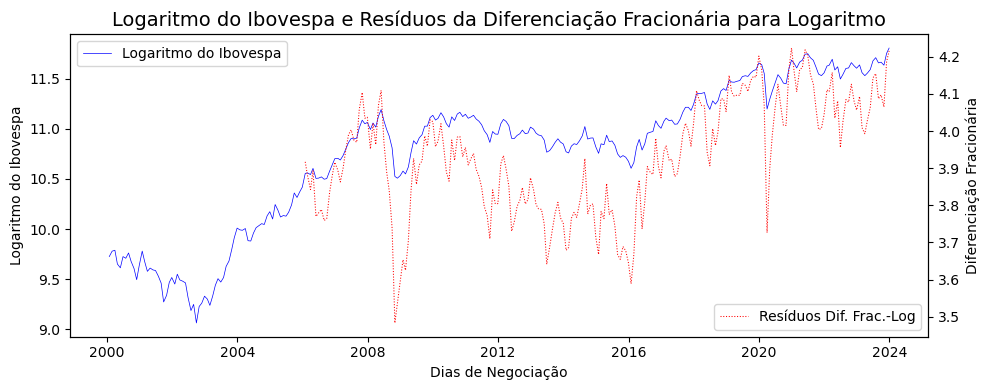

In [46]:
#===============================================================================================================================
# DATA: TRANSF - PLOT - LOG - SERIES vs RESIDUALS
#===============================================================================================================================
fig, ax1 = plt.subplots(figsize=(10,4))
ax1.plot(data['Close']     , 'b-',  label='Logaritmo do Ibovespa', linewidth=0.5)
ax1.legend(loc=2)
ax1.set_xlabel('Dias de Negociação')
ax1.set_ylabel('Logaritmo do Ibovespa')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.plot(fracdiff_residuals  , 'r', label='Resíduos Dif. Frac.-Log', linewidth=0.75 , linestyle='dotted')
ax2.set_ylabel('Diferenciação Fracionária')
ax2.legend(loc=4)

plt.title('Logaritmo do Ibovespa e Resíduos da Diferenciação Fracionária para Logaritmo', fontsize=14)
#fig.autofmt_xdate()
plt.tight_layout()
#plt.show()

In [33]:
fracdiff_residuals.to_csv('Data/Input/IBOV-FracDiff-Ln-Monthly.csv')

In [34]:
#===============================================================================================================================
# DATA: RECOVER - WEIGHTS - LOG
#===============================================================================================================================
w_FFD = getWeights_FFD(d, thres=1e-6, lim=5942-428+2)
print(len(w_FFD))
#w_FFD

5516


In [35]:
#===============================================================================================================================
# DATA: RECOVER - FRACDIFF - RUN - LOG
#===============================================================================================================================
fracdiff_recover = fracDiff_FFD_recover(fracdiff_residuals, d, THRESHOLD, w_FFD, data['Close'])


width= 5515 len(seriesF.index)= 216


Loop: iloc1= 0  | loc1= 2006-01-31 00:00:00

seriesF[loc1]= 3.917125815631911
series_ori[loc1]= 10.555364721564516
w[iloc1]= [-5.e-06]

Loop: iloc1= 1  | loc1= 2006-02-24 00:00:00

seriesF[loc1]= 3.881831612114482
series_ori[loc1]= 10.561276690217369
w[iloc1]= [-5.e-06]

Loop: iloc1= 2  | loc1= 2006-03-31 00:00:00

seriesF[loc1]= 3.8426654940271767
series_ori[loc1]= 10.544076691884909
w[iloc1]= [-5.e-06]

Loop: iloc1= 3  | loc1= 2006-04-28 00:00:00

seriesF[loc1]= 3.892926075120709
series_ori[loc1]= 10.605679208241265
w[iloc1]= [-5.e-06]

Loop: iloc1= 4  | loc1= 2006-05-31 00:00:00

seriesF[loc1]= 3.77001383973517
series_ori[loc1]= 10.505890214779148
w[iloc1]= [-5.e-06]

Loop: iloc1= 5  | loc1= 2006-06-30 00:00:00

seriesF[loc1]= 3.779638148782907
series_ori[loc1]= 10.508640873628556
w[iloc1]= [-5.e-06]

Loop: iloc1= 6  | loc1= 2006-07-31 00:00:00

seriesF[loc1]= 3.7887716728987195
series_ori[loc1]= 10.520755346760415
w[iloc1]= [-5.e-06]

Loop: ilo

series_ori[loc1]= 11.486517319193924
w[iloc1]= [-6.e-06]

Loop: iloc1= 157  | loc1= 2019-02-28 00:00:00

seriesF[loc1]= 4.10485657637706
series_ori[loc1]= 11.467764382709836
w[iloc1]= [-6.e-06]

Loop: iloc1= 158  | loc1= 2019-03-29 00:00:00

seriesF[loc1]= 4.094175648233197
series_ori[loc1]= 11.46598646633612
w[iloc1]= [-6.e-06]

Loop: iloc1= 159  | loc1= 2019-04-30 00:00:00

seriesF[loc1]= 4.097047282079501
series_ori[loc1]= 11.475777234739828
w[iloc1]= [-6.e-06]

Loop: iloc1= 160  | loc1= 2019-05-31 00:00:00

seriesF[loc1]= 4.096202833317193
series_ori[loc1]= 11.482778785962996
w[iloc1]= [-6.e-06]

Loop: iloc1= 161  | loc1= 2019-06-28 00:00:00

seriesF[loc1]= 4.128716944687212
series_ori[loc1]= 11.522550990604644
w[iloc1]= [-6.e-06]

Loop: iloc1= 162  | loc1= 2019-07-31 00:00:00

seriesF[loc1]= 4.1232196857334085
series_ori[loc1]= 11.530884531206429
w[iloc1]= [-6.e-06]

Loop: iloc1= 163  | loc1= 2019-08-30 00:00:00

seriesF[loc1]= 4.106863087065378
series_ori[loc1]= 11.52420768074799

In [36]:
#===============================================================================================================================
# DATA: RECOVER - FRACDIFF - LOG
#===============================================================================================================================
fracdiff_recover

,Close
2006-01-31,[10.555365]
2006-02-24,[10.561277]
2006-03-31,[10.544077]
2006-04-28,[10.605679]
2006-05-31,[10.50589]
...,...
2023-08-31,[11.659117]
2023-09-29,[11.666206]
2023-10-31,[11.636414]
2023-11-30,[11.754546]
